In [13]:
# Cropping the images according to the bounding boxes in order to create a dataset of images with equal dimensions and size.

from PIL import Image
import numpy as np

def resize_image(image_name):
    # image_path =  os.path.join(DATA_DIR, image_name)
    im = Image.open(image_name)
    width,height = im.size

    new_width = min(width,height)
    new_height = min(width,height)

    left = int(np.ceil((width - new_width)/2))
    top = int(np.ceil((height - new_height)/2))
    right = int(np.ceil((width + new_width)/2))
    bottom = int(np.ceil((height + new_height)/2))

    im = im.crop((left, top, right, bottom))
    # im.save(os.path.join(OUTPUT_DIR, image_name))
    return im

im = Image.open("1.jpg")
im.show()
gen_im = resize_image(image_name="1.jpg")
gen_im.show()


c:\Users\Tedd\AppData\Local\Programs\Python\Python310\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (5.0.0)/charset_normalizer (2.0.10) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████| 8/8 [05:45<00:00, 43.22s/it]


Epoch: [1/50], loss_d: 0.4207, loss_g: 9.1347, real_score: 0.8475, fake_score: 0.1857


100%|██████████| 8/8 [04:09<00:00, 31.20s/it]


Epoch: [2/50], loss_d: 1.2304, loss_g: 4.9391, real_score: 0.5753, fake_score: 0.2539


100%|██████████| 8/8 [03:47<00:00, 28.46s/it]


Epoch: [3/50], loss_d: 0.4825, loss_g: 5.2411, real_score: 0.8074, fake_score: 0.0895


100%|██████████| 8/8 [03:55<00:00, 29.45s/it]


Epoch: [4/50], loss_d: 0.4476, loss_g: 4.1731, real_score: 0.7193, fake_score: 0.0802


100%|██████████| 8/8 [03:49<00:00, 28.67s/it]


Epoch: [5/50], loss_d: 0.6251, loss_g: 6.2521, real_score: 0.9129, fake_score: 0.3807


100%|██████████| 8/8 [03:46<00:00, 28.32s/it]


Epoch: [6/50], loss_d: 0.5641, loss_g: 2.9742, real_score: 0.6638, fake_score: 0.0364


100%|██████████| 8/8 [03:46<00:00, 28.30s/it]


Epoch: [7/50], loss_d: 0.2605, loss_g: 5.6707, real_score: 0.9944, fake_score: 0.2210


100%|██████████| 8/8 [03:50<00:00, 28.83s/it]


Epoch: [8/50], loss_d: 0.2271, loss_g: 7.0666, real_score: 0.8192, fake_score: 0.0020


100%|██████████| 8/8 [03:45<00:00, 28.16s/it]


Epoch: [9/50], loss_d: 0.1051, loss_g: 4.8673, real_score: 0.9927, fake_score: 0.0919


100%|██████████| 8/8 [03:42<00:00, 27.78s/it]


Epoch: [10/50], loss_d: 0.2246, loss_g: 10.3685, real_score: 0.9856, fake_score: 0.1852


100%|██████████| 8/8 [03:43<00:00, 27.98s/it]


Epoch: [11/50], loss_d: 0.0935, loss_g: 7.4435, real_score: 0.9944, fake_score: 0.0829


100%|██████████| 8/8 [03:42<00:00, 27.81s/it]


Epoch: [12/50], loss_d: 0.0303, loss_g: 7.0705, real_score: 0.9970, fake_score: 0.0269


100%|██████████| 8/8 [03:41<00:00, 27.66s/it]


Epoch: [13/50], loss_d: 0.0170, loss_g: 7.0284, real_score: 0.9991, fake_score: 0.0159


100%|██████████| 8/8 [03:41<00:00, 27.66s/it]


Epoch: [14/50], loss_d: 0.1152, loss_g: 7.1263, real_score: 0.9313, fake_score: 0.0261


100%|██████████| 8/8 [03:42<00:00, 27.80s/it]


Epoch: [15/50], loss_d: 0.0139, loss_g: 6.7708, real_score: 0.9910, fake_score: 0.0048


100%|██████████| 8/8 [03:41<00:00, 27.64s/it]


Epoch: [16/50], loss_d: 0.0302, loss_g: 8.1650, real_score: 0.9988, fake_score: 0.0286


100%|██████████| 8/8 [03:40<00:00, 27.62s/it]


Epoch: [17/50], loss_d: 0.0244, loss_g: 6.6525, real_score: 0.9867, fake_score: 0.0107


100%|██████████| 8/8 [03:39<00:00, 27.48s/it]


Epoch: [18/50], loss_d: 0.0216, loss_g: 7.2108, real_score: 0.9887, fake_score: 0.0100


100%|██████████| 8/8 [03:43<00:00, 27.96s/it]


Epoch: [19/50], loss_d: 0.0100, loss_g: 6.9918, real_score: 0.9984, fake_score: 0.0084


100%|██████████| 8/8 [03:41<00:00, 27.74s/it]


Epoch: [20/50], loss_d: 0.0217, loss_g: 6.9996, real_score: 0.9906, fake_score: 0.0121


100%|██████████| 8/8 [03:40<00:00, 27.57s/it]


Epoch: [21/50], loss_d: 0.0340, loss_g: 6.5887, real_score: 0.9700, fake_score: 0.0027


100%|██████████| 8/8 [03:40<00:00, 27.62s/it]


Epoch: [22/50], loss_d: 0.0081, loss_g: 6.4641, real_score: 0.9994, fake_score: 0.0074


100%|██████████| 8/8 [03:42<00:00, 27.75s/it]


Epoch: [23/50], loss_d: 0.0067, loss_g: 6.9345, real_score: 0.9985, fake_score: 0.0052


100%|██████████| 8/8 [03:41<00:00, 27.73s/it]


Epoch: [24/50], loss_d: 0.0032, loss_g: 7.6207, real_score: 0.9987, fake_score: 0.0018


100%|██████████| 8/8 [03:41<00:00, 27.69s/it]


Epoch: [25/50], loss_d: 0.0115, loss_g: 6.8797, real_score: 0.9943, fake_score: 0.0057


100%|██████████| 8/8 [03:42<00:00, 27.85s/it]


Epoch: [26/50], loss_d: 0.0053, loss_g: 6.7973, real_score: 0.9975, fake_score: 0.0028


100%|██████████| 8/8 [03:42<00:00, 27.82s/it]


Epoch: [27/50], loss_d: 0.0058, loss_g: 6.5256, real_score: 0.9996, fake_score: 0.0054


100%|██████████| 8/8 [03:41<00:00, 27.72s/it]


Epoch: [28/50], loss_d: 0.0027, loss_g: 6.8830, real_score: 0.9997, fake_score: 0.0024


100%|██████████| 8/8 [03:40<00:00, 27.55s/it]


Epoch: [29/50], loss_d: 0.0507, loss_g: 6.1845, real_score: 0.9561, fake_score: 0.0036


100%|██████████| 8/8 [03:40<00:00, 27.54s/it]


Epoch: [30/50], loss_d: 0.0027, loss_g: 6.9712, real_score: 0.9999, fake_score: 0.0026


100%|██████████| 8/8 [03:43<00:00, 27.95s/it]


Epoch: [31/50], loss_d: 0.0144, loss_g: 6.6209, real_score: 0.9908, fake_score: 0.0051


100%|██████████| 8/8 [03:42<00:00, 27.85s/it]


Epoch: [32/50], loss_d: 0.0009, loss_g: 7.9274, real_score: 0.9996, fake_score: 0.0005


100%|██████████| 8/8 [03:43<00:00, 27.88s/it]


Epoch: [33/50], loss_d: 0.0050, loss_g: 7.1472, real_score: 0.9991, fake_score: 0.0041


100%|██████████| 8/8 [03:40<00:00, 27.58s/it]


Epoch: [34/50], loss_d: 0.0048, loss_g: 7.0664, real_score: 0.9965, fake_score: 0.0012


100%|██████████| 8/8 [03:44<00:00, 28.02s/it]


Epoch: [35/50], loss_d: 0.0142, loss_g: 7.6533, real_score: 0.9868, fake_score: 0.0006


100%|██████████| 8/8 [03:41<00:00, 27.71s/it]


Epoch: [36/50], loss_d: 0.0261, loss_g: 6.3091, real_score: 0.9762, fake_score: 0.0013


100%|██████████| 8/8 [03:40<00:00, 27.51s/it]


Epoch: [37/50], loss_d: 0.0116, loss_g: 6.1076, real_score: 0.9905, fake_score: 0.0019


100%|██████████| 8/8 [03:40<00:00, 27.52s/it]


Epoch: [38/50], loss_d: 0.0041, loss_g: 8.2894, real_score: 0.9962, fake_score: 0.0003


100%|██████████| 8/8 [03:41<00:00, 27.66s/it]


Epoch: [39/50], loss_d: 0.0025, loss_g: 8.6157, real_score: 0.9987, fake_score: 0.0011


100%|██████████| 8/8 [03:42<00:00, 27.76s/it]


Epoch: [40/50], loss_d: 0.0039, loss_g: 7.3429, real_score: 0.9998, fake_score: 0.0036


100%|██████████| 8/8 [03:41<00:00, 27.64s/it]


Epoch: [41/50], loss_d: 0.0005, loss_g: 9.8149, real_score: 0.9995, fake_score: 0.0001


100%|██████████| 8/8 [03:39<00:00, 27.48s/it]


Epoch: [42/50], loss_d: 0.0078, loss_g: 15.9646, real_score: 0.9923, fake_score: 0.0000


100%|██████████| 8/8 [03:42<00:00, 27.80s/it]


Epoch: [43/50], loss_d: 0.0344, loss_g: 5.1723, real_score: 0.9986, fake_score: 0.0323


100%|██████████| 8/8 [03:59<00:00, 29.90s/it]


Epoch: [44/50], loss_d: 0.8098, loss_g: 6.4304, real_score: 0.9552, fake_score: 0.4094


100%|██████████| 8/8 [03:43<00:00, 27.99s/it]


Epoch: [45/50], loss_d: 0.1023, loss_g: 5.5558, real_score: 0.9788, fake_score: 0.0725


100%|██████████| 8/8 [03:40<00:00, 27.57s/it]


Epoch: [46/50], loss_d: 0.1179, loss_g: 4.4204, real_score: 0.9424, fake_score: 0.0304


100%|██████████| 8/8 [03:41<00:00, 27.66s/it]


Epoch: [47/50], loss_d: 1.3519, loss_g: 4.9487, real_score: 0.8538, fake_score: 0.5483


100%|██████████| 8/8 [03:39<00:00, 27.47s/it]


Epoch: [48/50], loss_d: 0.7591, loss_g: 1.3044, real_score: 0.6380, fake_score: 0.1873


100%|██████████| 8/8 [03:51<00:00, 28.89s/it]


Epoch: [49/50], loss_d: 0.3791, loss_g: 2.0334, real_score: 0.8310, fake_score: 0.1608


100%|██████████| 8/8 [4:52:49<00:00, 2196.14s/it]    


Epoch: [50/50], loss_d: 0.5511, loss_g: 3.9613, real_score: 0.8423, fake_score: 0.2836


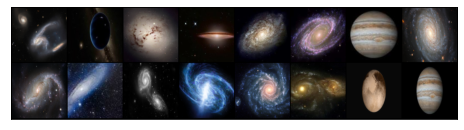

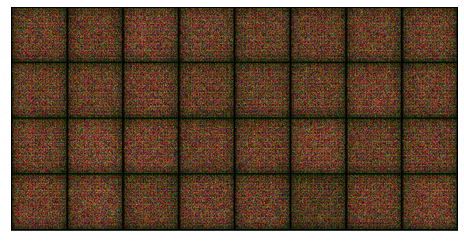

In [1]:
# Taking the image as input and generating a new image raw image.

import os
import torch
import torchvision
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import Image
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.utils import save_image

DATA_DIR = "./data/"

stats = (.5, .5, .5), (.5, .5, .5)

transform_ds = T.Compose([
    T.Resize((128, 128)),
    T.CenterCrop(128),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.ToTensor(),
    T.Normalize(*stats)
])
ds = torchvision.datasets.ImageFolder(root=DATA_DIR, transform=transform_ds)


def denorm(img_tensor):
    return img_tensor * stats[1][0] + stats[0][0]


batch_size = 16

train_dl = DataLoader(ds, batch_size, shuffle=True,
                      num_workers=3, pin_memory=True)


def show_image(train_dl):
    for images, _ in train_dl:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(
            make_grid(denorm(images.detach()[:32]), nrow=8).permute(1, 2, 0))
        break


show_image(train_dl)


def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")


def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for x in self.dl:
            yield to_device(x, self.device)

    def __len__(self):
        return len(self.dl)


device = get_device()

train_dl = DeviceDataLoader(train_dl, device)

discriminator = nn.Sequential(
    #in: 128 x 3 x 128 x 128

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    #128 x 64 x 64 x 64

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    #128 x 128 x 32 x 32

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    #128 x 256 x 16 x 16

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    #128 x 512 x 8 x 8

    nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.2, inplace=True),
    #128 x 1024 x 4 x 4

    nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0, bias=False),
    #128 x 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()

)

discriminator = to_device(discriminator, device)

latent_size = 128
generator = nn.Sequential(
    #in: 128 x 1 x 1

    nn.ConvTranspose2d(latent_size, 1024, kernel_size=4,
                       stride=1, padding=0, bias=False),
    nn.BatchNorm2d(1024),
    nn.ReLU(True),
    #128 x 1024 x 4 x 4

    nn.ConvTranspose2d(1024, 512, kernel_size=4,
                       stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    #128 x 512 x 8 x 8

    nn.ConvTranspose2d(512, 256, kernel_size=4,
                       stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    #128 x 256 x 16 x 16

    nn.ConvTranspose2d(256, 128, kernel_size=4,
                       stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    #128 x 128 x 32 x 32

    nn.ConvTranspose2d(128, 64, kernel_size=4,
                       stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    #128 x 64 x 64 x 64

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    #128 x 3 x 128 x 128
    nn.Tanh()


)


generator = to_device(generator, device)


def train_discriminator(real_images, opt_d):
    opt_d.zero_grad()

    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    latent = torch.randn(latent_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    fake_preds = discriminator(fake_images)
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    loss = real_loss + fake_loss
    loss.backward(),
    opt_d.step()

    return loss.item(), real_score, fake_score


def train_generator(opt_g):
    opt_g.zero_grad()

    latent = torch.randn(latent_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    preds = discriminator(fake_images)
    targets = torch.ones(fake_images.size(0), 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    loss.backward(),
    opt_g.step()

    return loss.item()


sample_dir = "generated"
os.makedirs(sample_dir, exist_ok=True)


def save_sample(index, fixed_latent, show=True):
    fake_images = generator(fixed_latent)
    fake_fname = "generated-images-{0:0=4d}.png".format(index)
    save_image(denorm(fake_images), os.path.join(
        sample_dir, fake_fname), nrow=8)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach()
                  [:32], nrow=8).permute(1, 2, 0))


fixed_latent = torch.randn(128, latent_size, 1, 1, device=device)
save_sample(0, fixed_latent, show=True)


def fit(epochs, lr_d, lr_g, start_idx=1):
    torch.cuda.empty_cache()

    losses_d = []
    losses_g = []
    real_scores = []
    fake_scores = []

    opt_d = torch.optim.Adam(discriminator.parameters(),
                             lr=lr_d, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(),
                             lr=lr_g, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            loss_d, real_score, fake_score = train_discriminator(
                real_images, opt_d)
            loss_g = train_generator(opt_g)

        losses_d.append(loss_d)
        losses_g.append(loss_g)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        print("Epoch: [{}/{}], loss_d: {:.4f}, loss_g: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_d, loss_g, real_score, fake_score))

        save_sample(epoch+start_idx, fixed_latent, show=False)

    return losses_d, losses_g, real_scores, fake_scores


epochs = 50
lr_d = 10e-5
lr_g = 10e-4

history = [fit(epochs, lr_d, lr_g, start_idx=1)]

In [2]:
# print discriminiator state
print("Discriminator's state_dict:")
for param_tensor in discriminator.state_dict():
    print(param_tensor, "\t", discriminator.state_dict()[param_tensor].size())

Discriminator's state_dict:
0.weight 	 torch.Size([64, 3, 4, 4])
1.weight 	 torch.Size([64])
1.bias 	 torch.Size([64])
1.running_mean 	 torch.Size([64])
1.running_var 	 torch.Size([64])
1.num_batches_tracked 	 torch.Size([])
3.weight 	 torch.Size([128, 64, 4, 4])
4.weight 	 torch.Size([128])
4.bias 	 torch.Size([128])
4.running_mean 	 torch.Size([128])
4.running_var 	 torch.Size([128])
4.num_batches_tracked 	 torch.Size([])
6.weight 	 torch.Size([256, 128, 4, 4])
7.weight 	 torch.Size([256])
7.bias 	 torch.Size([256])
7.running_mean 	 torch.Size([256])
7.running_var 	 torch.Size([256])
7.num_batches_tracked 	 torch.Size([])
9.weight 	 torch.Size([512, 256, 4, 4])
10.weight 	 torch.Size([512])
10.bias 	 torch.Size([512])
10.running_mean 	 torch.Size([512])
10.running_var 	 torch.Size([512])
10.num_batches_tracked 	 torch.Size([])
12.weight 	 torch.Size([1024, 512, 4, 4])
13.weight 	 torch.Size([1024])
13.bias 	 torch.Size([1024])
13.running_mean 	 torch.Size([1024])
13.running_var 	 tor

In [5]:
# print generator state
print("generator's state_dict:")
for param_tensor in generator.state_dict():
    print(param_tensor, "\t", generator.state_dict()[param_tensor].size())

generator's state_dict:
0.weight 	 torch.Size([128, 1024, 4, 4])
1.weight 	 torch.Size([1024])
1.bias 	 torch.Size([1024])
1.running_mean 	 torch.Size([1024])
1.running_var 	 torch.Size([1024])
1.num_batches_tracked 	 torch.Size([])
3.weight 	 torch.Size([1024, 512, 4, 4])
4.weight 	 torch.Size([512])
4.bias 	 torch.Size([512])
4.running_mean 	 torch.Size([512])
4.running_var 	 torch.Size([512])
4.num_batches_tracked 	 torch.Size([])
6.weight 	 torch.Size([512, 256, 4, 4])
7.weight 	 torch.Size([256])
7.bias 	 torch.Size([256])
7.running_mean 	 torch.Size([256])
7.running_var 	 torch.Size([256])
7.num_batches_tracked 	 torch.Size([])
9.weight 	 torch.Size([256, 128, 4, 4])
10.weight 	 torch.Size([128])
10.bias 	 torch.Size([128])
10.running_mean 	 torch.Size([128])
10.running_var 	 torch.Size([128])
10.num_batches_tracked 	 torch.Size([])
12.weight 	 torch.Size([128, 64, 4, 4])
13.weight 	 torch.Size([64])
13.bias 	 torch.Size([64])
13.running_mean 	 torch.Size([64])
13.running_var 	 t

In [7]:
torch.save(discriminator.state_dict(), "models/discriminator.pth")

In [8]:
torch.save(discriminator.state_dict(), "models/generator.pth")

In [9]:
dis = torch.load("models/discriminator.pth")
gen = torch.load("models/generator.pth")

In [14]:
im = Image.open("1.jpg")